In [2]:
# Import Libraries

import numpy as np
import h5py
import os

import math
import matplotlib.pyplot as plt
from PIL import Image

import torch
import h5py

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rcParams.update({'font.size': 12})



In [3]:
tag="Volume"
slice_id = 1000
LineofDraw1 = 940

pixres1 = 2000
pixres2 = 3000
#XZ = [533:2411,slice_id,461:2492]
#_YZ = [slice_id,:,500:2500]

In [4]:
fnn = '/import/scratch/tmp-ct-3/Ammar/AluCube_Compression/CtutilRealReco_WithoutNoiseWithBH/volume.hdf5'
volumeWithBH_YZ=h5py.File(fnn,'r')[tag][slice_id,:,500:2500]   #Data to be denoised

fnn = '/import/scratch/tmp-ct-3/Ammar/AluCube_Compression/CtutilRealReco_WithArtifacts/volume.hdf5'
volumeWithArtifacts_YZ=h5py.File(fnn,'r')[tag][slice_id,:,500:2500] 

fnn = '/import/scratch/tmp-ct-3/Ammar/AluCube_Compression/CtutilRealReco_WithoutArtifacts/volume.hdf5'
volumeWithoutArtifacts_YZ=h5py.File(fnn,'r')[tag][slice_id,:,500:2500] 

In [19]:
def calculate_patch_size(image_shape, desired_num_patches=100, min_patch_size=(100, 100)):
    """
    Calculates the patch size based on the image size, desired number of patches, and minimum patch size.
    The function tries to generate a number of patches close to the desired number without going below the minimum size.
    """
    img_height, img_width = image_shape[:2]
    patch_height, patch_width = min_patch_size
    
    # Start with the minimum patch size and adjust if necessary to not exceed desired_num_patches
    num_patches_x = max(1, img_width // patch_width)
    num_patches_y = max(1, img_height // patch_height)
    
    # Adjust the number of patches to not exceed the desired number
    while num_patches_x * num_patches_y > desired_num_patches:
        patch_width += 1
        patch_height += 1
        num_patches_x = max(1, img_width // patch_width)
        num_patches_y = max(1, img_height // patch_height)
        
    return (patch_height, patch_width), (num_patches_y, num_patches_x)

def divide_image_into_patches(image, patch_size):
    """
    Divides the given image into patches of the specified size.
    """
    patches = []
    patch_height, patch_width = patch_size
    img_height, img_width = image.shape[:2]
    
    num_patches_y = img_height // patch_height
    num_patches_x = img_width // patch_width
    
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            start_y = i * patch_height
            start_x = j * patch_width
            patch = image[start_y:start_y+patch_height, start_x:start_x+patch_width]
            patches.append(patch)
            
    return patches

def ensure_dir_exists(directory):
    """
    Ensures that the directory exists, creating it if necessary.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

def save_patches(patches, folder, prefix):
    """
    Saves patches to the specified folder with the given prefix.
    """
    # Ensure the folder exists
    ensure_dir_exists(folder)
        
    for i, patch in enumerate(patches):
        filename = os.path.join(folder, f"{prefix}_{i}.png")
        plt.imsave(filename, patch, cmap='gray')


In [29]:
# File paths and parameters
fnn_with_artifacts = '/import/scratch/tmp-ct-3/Ammar/AluCube_Compression/CtutilRealReco_WithArtifacts/volume.hdf5'
fnn_without_artifacts = '/import/scratch/tmp-ct-3/Ammar/AluCube_Compression/CtutilRealReco_WithoutNoiseWithBH/volume.hdf5'

train_source = "data/train/source/"
valid_source = "data/valid/source/"

train_target = "data/train/target/"
valid_target = "data/valid/target/"

# Load images
with h5py.File(fnn_with_artifacts, 'r') as f:
    volumeWithArtifacts_YZ = f[tag][slice_id,:,500:2500]
    volumeWithArtifacts_YZ_2 = f[tag][slice_id+10,:,500:2500]
with h5py.File(fnn_without_artifacts, 'r') as f:
    volumeWithoutArtifacts_YZ = f[tag][slice_id,:,500:2500]
    volumeWithoutArtifacts_YZ_2 = f[tag][slice_id+10,:,500:2500]

# Ensure both images are the same size
assert volumeWithArtifacts_YZ.shape == volumeWithoutArtifacts_YZ.shape, "Images must have the same shape"

# Calculate patch size
patch_size, _ = calculate_patch_size(volumeWithArtifacts_YZ.shape, min_patch_size=(256, 256))

# Divide images into patches
patches_with_artifacts = divide_image_into_patches(volumeWithArtifacts_YZ, patch_size)
patches_with_artifacts_2 = divide_image_into_patches(volumeWithArtifacts_YZ_2, patch_size)

patches_without_artifacts = divide_image_into_patches(volumeWithoutArtifacts_YZ, patch_size)
patches_without_artifacts_2 = divide_image_into_patches(volumeWithoutArtifacts_YZ_2, patch_size)

# Save patches in target
save_patches(patches_with_artifacts, train_source, "patch")
save_patches(patches_with_artifacts_2, train_target, "patch")

# Save patches in validation
save_patches(patches_with_artifacts, valid_source, "patch")
save_patches(patches_with_artifacts_2, valid_target, "patch")

print(f"Patches saved. Number of patches: {len(patches_with_artifacts)}")


Patches saved. Number of patches: 49


In [9]:
fnn = '/import/scratch/tmp-ct-3/Ammar/AluCube_Compression/CtutilRealReco_WithArtifacts/volume.hdf5'
volumeWithArtifacts_XZ=h5py.File(fnn,'r')["Volume"][533:2411,1200,461:2492] 
plt.imsave("/zhome/ahmadfn/Desktop/N2N/N2NDenoisingCT/Noise2Noise/noise2noise/data/test/volumeWithArtifacts_XZ.png",volumeWithArtifacts_XZ,cmap='gray')

In [6]:

plt.imsave("/zhome/ahmadfn/Desktop/N2N/N2NDenoisingCT/Noise2Noise-CT/noise2noise/data/test/volumeWithArtifacts_YZ.png",h5py.File(fnn,'r')[tag][1000,:,500:2500],cmap='gray')

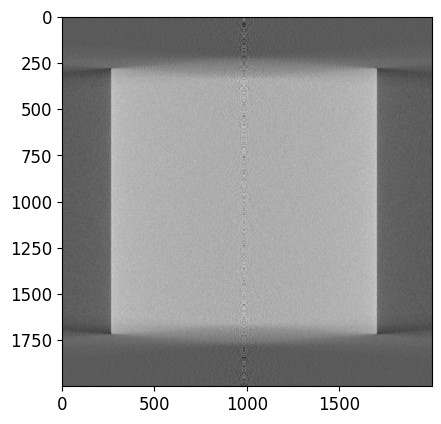

In [35]:
fnn = '/import/scratch/tmp-ct-3/Ammar/AluCube_Compression/CtutilRealReco_WithArtifacts/volume.hdf5'
volumeWithArtifacts_YZ_diff=h5py.File(fnn,'r')[tag][slice_id+500,:,500:2500]
plt.imshow(volumeWithArtifacts_YZ_diff,cmap='gray')

In [7]:
plt.imsave("/zhome/ahmadfn/Desktop/N2N/N2NDenoisingCT/Noise2Noise-CT/noise2noise/data/GT/volumeWithBH_YZ.png",volumeWithBH_YZ,cmap='gray')

In [25]:
os.getcwd()


'/zhome/ahmadfn/Desktop/N2N/N2NDenoisingCT/Noise2Noise-CT/src'